In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets, model_selection

from tensorflow import keras
from tensorflow.keras import layers

from keras.wrappers.scikit_learn import KerasClassifier

import time

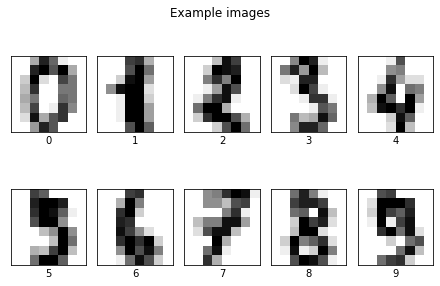

In [3]:
# Load dataset
digits = datasets.load_digits()

fig, axes = plt.subplots(2, 5, constrained_layout=True)

fig.suptitle('Example images')

for ax, im, tar in zip(axes.flatten(), digits.images, digits.target):
    ax.imshow(im, cmap='gray_r')

    ax.set_xlabel(tar)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [4]:
# Preprocess and split the data
n_classes = len(digits.target_names)
n_features = np.prod(digits.data.shape[1:])

X = digits.data/digits.data.max()
y = digits.target

X_trainval, X_test, y_trainval, y_test = (model_selection.
                                          train_test_split(X, y, stratify=y,
                                                            random_state=0))

In [5]:
# Define sklearn classifier
def make_model(hidden_units1, hidden_units2, l2_strength):
    model = keras.Sequential([
        layers.InputLayer(input_shape=(n_features,)),
        layers.Dense(hidden_units1, activation='relu', 
                     kernel_regularizer=keras.regularizers.l2(l2_strength)),
        layers.Dense(hidden_units2, activation='relu',
                     kernel_regularizer=keras.regularizers.l2(l2_strength)),
        layers.Dense(n_classes, activation='softmax',
                     kernel_regularizer=keras.regularizers.l2(l2_strength))
    ])

    model.compile(optimizer='adam', loss="categorical_crossentropy",
                  metrics=['accuracy'])
    
    return model


# Override KerasClassifier so as to control the epochs and the verbosity level
class SilentKerasClassifier(KerasClassifier):

    def fit(self, X, y):
      return super().fit(X, y, epochs=10, verbose=0)

    def score(self, X, y):
      return super().score(X, y, verbose=0)


model = SilentKerasClassifier(make_model)

# Sanity check the model architecture
make_model(64, 32, 0.01).summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 6,570
Trainable params: 6,570
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Randomized hyperparameter search
param_grid = {
    'hidden_units1': (n_features * np.logspace(-2, 1, num=10, base=2))
                        .astype(int).tolist(),
    'hidden_units2': (n_features * np.logspace(-2, 1, num=10, base=2))
                        .astype(int).tolist(),
    'l2_strength': np.logspace(-12, 0, base=10, num=10).tolist()
}

splitter = model_selection.StratifiedShuffleSplit(1, random_state=0)

grid = model_selection.RandomizedSearchCV(model,
                                          param_distributions=param_grid,
                                          cv=splitter,
                                          n_iter=200,
                                          return_train_score=True)
grid.fit(X_trainval, y_trainval)

res = pd.DataFrame(grid.cv_results_)[['param_hidden_units1', 
                                      'param_hidden_units2',
                                      'param_l2_strength',
                                      'mean_train_score',
                                      'mean_test_score']]

res.sort_values(by=['mean_test_score', 'mean_train_score'], ascending=False, 
                inplace=True)

res[:10]

,param_hidden_units1,param_hidden_units2,param_l2_strength,mean_train_score,mean_test_score
8,128,101,4.64159e-10,0.991749,0.977778
116,101,101,1e-08,0.988449,0.977778
63,80,128,1e-08,0.985148,0.977778
160,80,101,1e-12,0.981848,0.977778
38,50,101,1e-08,0.981023,0.977778
28,40,64,4.64159e-10,0.978548,0.977778
90,101,40,0.00215443,0.972772,0.977778
176,128,16,2.15443e-07,0.969472,0.977778
111,64,128,1e-08,0.988449,0.970370
140,128,128,1e-08,0.986799,0.970370


Test accuracy: 0.9688888788223267


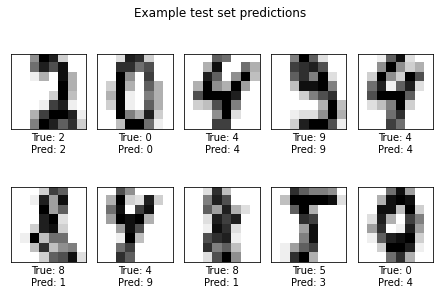

In [7]:
# Evaluate performance on the test set
print('Test accuracy:', grid.score(X_test, y_test))

y_pred = np.argmax(grid.predict_proba(X_test), axis=1)
errors = y_test != y_pred

fig, axes = plt.subplots(2, 5, constrained_layout=True)

fig.suptitle('Example test set predictions')

im_size = int(np.sqrt(n_features))

def plot_predictions(axes, X, true, pred):
    for ax, im, y_t, y_p in zip(axes, X, true, pred):
        ax.imshow(im.reshape(im_size, -1), cmap='gray_r')
                
        ax.set_xlabel('True: {}\nPred: {}'.format(y_t, y_p))

        ax.set_xticks([])
        ax.set_yticks([])
                      
plot_predictions(axes[0], X_test[~errors], y_test[~errors], y_pred[~errors])
plot_predictions(axes[1], X_test[errors], y_test[errors], y_pred[errors])

plt.show()